# Basics of Zipline API for Trading

1) Creating Basic Framework of zipline code

2) Simulating trade with a simple examples:

2.1) buy_ten_stock daily strategy (b_t_s)

2.2) Aroon (up/down) strategy (aroon)

2.3) Dual_moving_average_crossover strategy (d_m_a_c)

Note: Due to AAPL stock split around June 2014, it would be best to use other stocks(MSFT for this example) as research example to prevent confusion in portfolio returns for the trade strategies below.

## 1)

In [ ]:
#### Example framework of executing trade strategy
def initialize(context):
    # Pass initial informations regarding trade  into 'context' variable(global variable)
    # Exp: stock symbol, ...etc or include them in the zipline algorithm as inputs
        
def handle_data(context, data):
    # Code execution of trade strategy (conditions to long, short asset [context.order()]), tech indicator used
    # Recording portfolio values at interval (cash value and asset hold value [context.record()])
    # For simplicity of example, there will be no shorting stock, only long stock only if there is sufficient cash

# Execute strategy with obtained asset data('panel' for example below) and other inputs(start and end date of data,
# initial capital,initialize function, handle_data function,...etc )
# Storing output in a variable 'perf'

per=TechnicalIndicator_Name().run(start_date, end_date,initialize, handle_data, data)

## 2)

### 2.1) buy_ten_stock daily strategy (b_t_s)

In [1]:
# package to extract stock data from alpha_vantage API
from alpha_vantage.timeseries import TimeSeries

# package to plot 
import matplotlib.pyplot as plt

# package to check and set directory
import os

# package to use pandas DataFrame or Pandas
import pandas as pd

# packages to execute excel spreadsheet conversion function
import openpyxl
import xlrd

# Required to set datetimes for zipline algorithm later
import pytz

In [2]:
# get current directory
os.getcwd()

'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1'

In [3]:
# set path as current directory
os.chdir('C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1')

In [4]:
# Execute functions with API keys
with open('ak.txt', 'r') as myFile:
    keys=myFile.read()
    ts=TimeSeries(key=keys, output_format='pandas')

In [5]:
# Extract data of interest('AAPL' stock this case)
symbol='MSFT'
columns=['open', 'volume', 'low', 'close', 'high']
#data0, meta_data0=ts.get_intraday(symbol='AAPL', interval='5min', outputsize='full')
data0, meta_data0=ts.get_daily(symbol='MSFT', outputsize='full')
data0.head()

,5. volume,1. open,4. close,3. low,2. high
date,,,,,
2000-01-07,31006800.0,108.62,111.44,107.31,112.25
2000-01-10,22481800.0,113.44,112.25,111.37,113.69
2000-01-11,23371800.0,111.50,109.37,108.69,114.25
2000-01-12,33266200.0,108.50,105.81,104.44,108.87
2000-01-13,41572000.0,104.37,107.81,101.50,108.62


In [6]:
# Rename column names in accordance with zipline algorithm column name
data0=data0.rename({"1. open": "open", "5. volume": "volume", "2. high": "high", "4. close": "close", "3. low":"low"}, axis='columns')
# Rearranging columns by OHLC format then volume
data0=data0[['open', 'high', 'low', 'close', 'volume']]
data0.head()

,open,high,low,close,volume
date,,,,,
2000-01-07,108.62,112.25,107.31,111.44,31006800.0
2000-01-10,113.44,113.69,111.37,112.25,22481800.0
2000-01-11,111.50,114.25,108.69,109.37,23371800.0
2000-01-12,108.50,108.87,104.44,105.81,33266200.0
2000-01-13,104.37,108.62,101.50,107.81,41572000.0


In [7]:
# Export Dataframe(d0) to excel spreadsheet to be extracted in excel format
from collections import OrderedDict

data = OrderedDict()
path_xlsx=r'C:\\Users\\UX330\\Documents\\A Uni\\Git\\Python project self research\\Project 1\\csvdir\\daily\\aapl.xlsx'
data_ex=data0.to_excel(path_xlsx)
data['MSFT']=pd.read_excel(path_xlsx, index_col='date')
print(data['MSFT'].tail())

# Remove excel file so new data can be generated with the same .xlsx file name tommorow
os.remove(path_xlsx)

# Display last few data points, here end_date is found to be 2020-01-08 which will later be used in trade algorithm

              open     high       low   close    volume
date                                                   
2020-01-02  158.78  160.730  158.3300  160.62  22634546
2020-01-03  158.32  159.945  158.0600  158.62  21121681
2020-01-06  157.08  159.100  156.5100  159.03  20826702
2020-01-07  159.32  159.670  157.3200  157.58  21881740
2020-01-08  158.93  160.800  157.9491  160.09  27552683


In [8]:
# Display first few data points, here start_date is found to be 2000-01-07 which will later be used in trade algorithm
print(data['MSFT'].head())

              open    high     low   close    volume
date                                                
2000-01-07  108.62  112.25  107.31  111.44  31006800
2000-01-10  113.44  113.69  111.37  112.25  22481800
2000-01-11  111.50  114.25  108.69  109.37  23371800
2000-01-12  108.50  108.87  104.44  105.81  33266200
2000-01-13  104.37  108.62  101.50  107.81  41572000


In [9]:
# minor_axis being axis 1, major_axis being axis 2
# localizing date by utc timezone for major_axis
# axis 1 consisting of stock name 'AAPL'
# axis 2 consisting of 5 column names (close, high, open, low, volume)
# axis 3 consisting of all datas of the 5 column names for each date
panel = pd.Panel(data)
panel.minor_axis = columns
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 5032 (major_axis) x 5 (minor_axis)
Items axis: MSFT to MSFT
Major_axis axis: 2000-01-07 00:00:00+00:00 to 2020-01-08 00:00:00+00:00
Minor_axis axis: open to high


In [10]:
# b_t_s being short notation of buy ten stocks daily strategy

from zipline.api import order, record, symbol, set_benchmark
import zipline
from datetime import datetime


def initialize_b_t_s(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('AAPL')
    set_benchmark(symbol("MSFT"))


def handle_data_b_t_s(context, data):
    # Example strategy
    # Order 10 AAPL stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    # Record all data (some are self generated from algorithm, shown below in Out[17])
    order(symbol("MSFT"), 10)
    record(MSFT=data.current(symbol('MSFT'), 'price'))

# Run zipline algorithm with necessary inputs like time period, 
# initialize(def), handle_data(def), capiatl, and data(panel)
# Note: Please change start and end date accoring to date of data
b_t_s_perf = zipline.run_algorithm(start=datetime(2000, 1, 7, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 1, 8, 0, 0, 0, 0, pytz.utc),
                      capital_base=100000,
                      initialize=initialize_b_t_s,
                      handle_data=handle_data_b_t_s,
                      data=panel)

In [11]:
# Below shows all the output data produced from the algorithm
b_t_s_perf.head()

,MSFT,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-07 21:00:00+00:00,111.44,NaN,0.000000,NaN,0.025962,NaN,NaN,0.00000,100000.00000,0.0,...,0.0,0.0,0,NaN,100000.00000,0.0,0.0,1,[],0.0
2000-01-10 21:00:00+00:00,112.25,0.000064,-0.000006,-0.001999,0.033419,0.209835,0.000306,-1123.07125,98876.92875,1122.5,...,0.0,0.0,0,-11.224972,100000.00000,0.0,0.0,2,"[{'sid': Equity(0 [MSFT]), 'amount': 10, 'pric...",0.0
2000-01-11 21:00:00+00:00,109.37,0.002665,-0.000299,-0.028980,0.006905,0.414872,0.006037,-1094.25685,97782.67190,2187.4,...,0.0,0.0,0,-9.341725,98876.92875,1122.5,1122.5,3,"[{'sid': Equity(0 [MSFT]), 'amount': 10, 'pric...",0.0
2000-01-12 21:00:00+00:00,105.81,0.005365,-0.001017,-0.047220,-0.025870,0.438463,0.010704,-1058.63905,96724.03285,3174.3,...,0.0,0.0,0,-10.409827,97782.67190,2187.4,2187.4,4,"[{'sid': Equity(0 [MSFT]), 'amount': 10, 'pric...",0.0
2000-01-13 21:00:00+00:00,107.81,0.007612,-0.000422,-0.016701,-0.007457,0.419591,0.014881,-1078.64905,95645.38380,4312.4,...,0.0,0.0,0,-3.861843,96724.03285,3174.3,3174.3,5,"[{'sid': Equity(0 [MSFT]), 'amount': 10, 'pric...",0.0


In [12]:
b_t_s_perf[['starting_cash', 'ending_cash', 'capital_used']].head()
# As shown above, zipline algoritm returns interesting outputs (volatiity, alpha value, beta value, ending_cash,...etc)

# ending_cash is the amount of capital(in cash) left at the end of the time period
# starting_cash-capital_used=ending_cash of that date

,starting_cash,ending_cash,capital_used
2000-01-07 21:00:00+00:00,100000.00000,100000.00000,0.00000
2000-01-10 21:00:00+00:00,100000.00000,98876.92875,-1123.07125
2000-01-11 21:00:00+00:00,98876.92875,97782.67190,-1094.25685
2000-01-12 21:00:00+00:00,97782.67190,96724.03285,-1058.63905
2000-01-13 21:00:00+00:00,96724.03285,95645.38380,-1078.64905


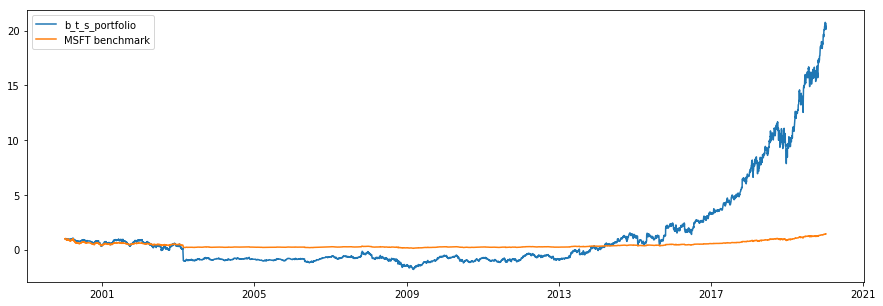

In [13]:
# Plotting MSFT benchmark and portfolio cumulative daily returns to understand b_t_s trade strategy performance
plt.figure(figsize=(15,5))
b_t_s_portfolio_daily_ret=b_t_s_perf.portfolio_value.pct_change()
MSFT_daily_ret=b_t_s_perf.MSFT.pct_change()

plt.plot((1+b_t_s_portfolio_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('b_t_s_portfolio', 'MSFT benchmark'), loc=0)

plt.show()

# Summary on b_t_s strategy (buy and hold stock):

-Strategy would not be profitable in early to mid years as portfolio returns remains below the MSFT benchmark.

-Strategy would be profitable only in late years if investor decides to stick to the b_t_s strategy despite lower early mid years returns as portfolio returns rises around after year 2013

-Valid as a long term strategy.

### 2.2) Aroon (up/down) strategy (aroon)

In [14]:
from zipline.api import order, order_target_percent, record, symbol, set_benchmark, get_open_orders 
import zipline
from datetime import datetime

# nanargmax extracts index of max value excluding any NaN values
# nanargmin extracts index of min value excluding any NaN values
from zipline.utils.math_utils import (
    nanargmax,
    nanargmin,
)

def initialize_aroon(context, window_length=42):
    set_benchmark(symbol("MSFT"))
    context.stock=symbol("MSFT")
    context.window=window_length
    context.counter=0
    context.hold=0
    
def handle_data_aroon(context, data):
    # Example strategy
    # Aroon_up: Extract index of (max 'high' price of stock of the window_length), then multiplied by*100, divided by window_length-1
    # Aroon_down: Extract index of (min 'low' price of stock of the window_length), then multiplied by*100, divided by window_length-1
    # If Aroon_up>70 & Aroon_down<30, buy stock (Aroon value implies more likely strong upward price trend)
    # If Aroon_up<30 & Aroon_down>70, do nothing (Aroon value implies more likely strong downard price trend)
    
    record(MSFT=data.current(symbol('MSFT'), 'price'))
    context.counter=context.counter+1
    
    # If stetment staes that below code not executed unless for first 42 data points since window_length is 42
    if context.counter<42:
        return
    
    window_length = context.window
    high_date_index = nanargmax(data.history(context.stock, 'high', 42, '1d'))
    low_date_index = nanargmin(data.history(context.stock, 'low', 42, '1d'))
    
    aroon_up=(100*high_date_index)/(window_length-1)
    aroon_down=(100*low_date_index)/(window_length-1)
    
    
    open_orders=get_open_orders()
    # if statement of open_orders to ensure there is still enough cash to buy stock or else don't buy
    if context.stock not in open_orders:
        if aroon_up>70 and aroon_down<30:
            order_target_percent(context.stock, 1.0)
        
        elif aroon_up<30 and aroon_down>70:
            order_target_percent(context.stock, 0.0)
            
        else:
            pass
        
    record(MSFT=data.current(symbol("MSFT"), 'price'), Aroon_up=aroon_up, Aroon_down=aroon_down)

# Note: Please change start and end date accoring to date of data
aroon_perf = zipline.run_algorithm(start=datetime(2000, 1, 7, 0, 0, 0, 0, pytz.utc),
                                   end=datetime(2020, 1, 8, 0, 0, 0, 0, pytz.utc),
                                   capital_base=100000,
                                   initialize=initialize_aroon,
                                   handle_data=handle_data_aroon,
                                   data=panel)
                                   
                    

C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


<Figure size 432x288 with 0 Axes>

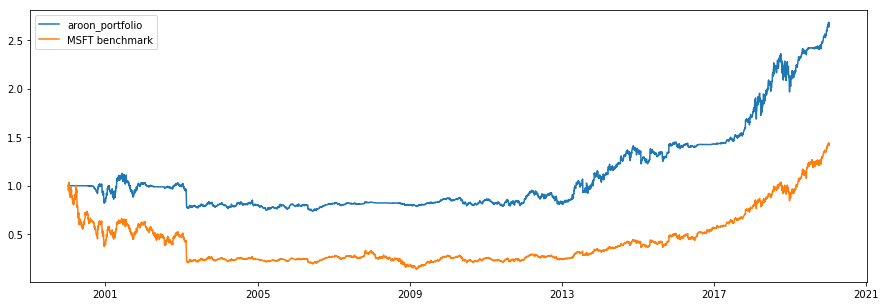

In [15]:
# Plotting MSFT benchmark and portfolio cumulative daily returns to understand aroon trade strategy performance
plt.clf()
plt.figure(figsize=(15,5))
aroon_portfolio_daily_ret=aroon_perf.portfolio_value.pct_change()
MSFT_daily_ret=aroon_perf.MSFT.pct_change()

plt.plot((1+aroon_portfolio_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('aroon_portfolio', 'MSFT benchmark'), loc=0)

plt.show()

# Summary on aroon_strategy (buy and hold stock):

-Strategy has performed well above the MSFT benchmark returns throughout the years even during the economy crisis(2008-2009)

-But compared to b_t_s startegy, the long term profit from would be lower (only 2.5+ for aroon, 20+ for b_t_s, that is if investor even decides to hold on to stocks despite economy crisis...)

-Might be best suited for a short/mid term strategy (since profit margin is not big but strategy returns are not extremely volatile, maintaining above the benchmark returns)

### 2.3) Dual_moving_average_crossover strategy (d_m_a_c)

In [16]:
# d_m_a_c being short notation of dual moving average crossover strategy

from zipline.api import order, order_target_percent, record, symbol, set_benchmark, get_open_orders
import zipline
from datetime import datetime


def initialize_d_m_a_c(context):
    # adds Series data formatting to results for algorithm performance comparison with benchmark('AAPL')
    set_benchmark(symbol("MSFT"))
    context.stock=symbol('MSFT')
    context.i=0

def handle_data_d_m_a_c(context, data):
    # Example strategy
    # Order 10 AAPL stocks everyday as long as there is still enough cash(initial capital-stock hold value)
    # If long moving average > short moving average, hold stock(do nothing)
    # If long moving average < short moving average, buy stock
    
    record(AAPL=data.current(symbol('MSFT'), 'price'))
    
    context.i=context.i+1

    # If statement states that below code not executed for first 250 data points since largest window_length os 250
    if context.i<250:
        #print(context.i)
        return
    
    msft_smavg = data.history(context.stock, 'price', bar_count=50, frequency="1d").mean()
    msft_lmavg = data.history(context.stock, 'price', bar_count=250, frequency="1d").mean()
    
    open_orders = get_open_orders()
    
    if context.stock not in open_orders:
        if msft_smavg>msft_lmavg:
            order_target_percent(context.stock, 1.0)
    
        elif msft_smavg<msft_lmavg:
            order_target_percent(context.stock, 0.0)
    
    record(MSFT=data.current(symbol('MSFT'), 'price'), short_mavg=msft_smavg, long_mavg=msft_lmavg)

d_m_a_c_perf = zipline.run_algorithm(start=datetime(2000, 1, 7, 0, 0, 0, 0, pytz.utc),
                      end=datetime(2020, 1, 8, 0, 0, 0, 0, pytz.utc),
                      capital_base=100000,
                      initialize=initialize_d_m_a_c,
                      handle_data=handle_data_d_m_a_c,
                      data=panel)

C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
C:\Users\UX330\Anaconda3\envs\env_zipline\lib\site-packages\empyrical\stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [17]:
# Note that first 250 days of output return data would be NaN or zero as long_mvag window length is 250
# So would the ending_cash remain the same for the first 250 day period
d_m_a_c_perf[:100]

,AAPL,MSFT,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,...,short_mavg,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-07 21:00:00+00:00,111.44,NaN,NaN,0.0,NaN,0.025962,NaN,NaN,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,1,[],0.0
2000-01-10 21:00:00+00:00,112.25,NaN,0.0,0.0,0.0,0.033419,0.209835,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,2,[],0.0
2000-01-11 21:00:00+00:00,109.37,NaN,0.0,0.0,0.0,0.006905,0.414872,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,3,[],0.0
2000-01-12 21:00:00+00:00,105.81,NaN,0.0,0.0,0.0,-0.025870,0.438463,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,4,[],0.0
2000-01-13 21:00:00+00:00,107.81,NaN,0.0,0.0,0.0,-0.007457,0.419591,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,5,[],0.0
2000-01-14 21:00:00+00:00,112.25,NaN,0.0,0.0,0.0,0.033419,0.465130,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,6,[],0.0
2000-01-18 21:00:00+00:00,115.31,NaN,0.0,0.0,0.0,0.061591,0.443609,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,7,[],0.0
2000-01-19 21:00:00+00:00,107.00,NaN,0.0,0.0,0.0,-0.014914,0.612558,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,8,[],0.0
2000-01-20 21:00:00+00:00,106.00,NaN,0.0,0.0,0.0,-0.024121,0.574610,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,9,[],0.0
2000-01-21 21:00:00+00:00,103.75,NaN,0.0,0.0,0.0,-0.044835,0.550176,0.0,0.0,100000.0,...,NaN,0.0,0,NaN,100000.0,0.0,0.0,10,[],0.0


In [18]:
# starting_cash-ending_cash=capital_used
d_m_a_c_perf[['starting_cash', 'ending_cash', 'capital_used']][350:375]

,starting_cash,ending_cash,capital_used
2001-05-30 20:00:00+00:00,100000.000000,100000.000000,0.000000
2001-05-31 20:00:00+00:00,100000.000000,99515.490870,-484.509130
2001-06-01 20:00:00+00:00,99515.490870,99022.857680,-492.633190
2001-06-04 20:00:00+00:00,99022.857680,98527.142950,-495.714730
2001-06-05 20:00:00+00:00,98527.142950,98018.681850,-508.461100
2001-06-06 20:00:00+00:00,98018.681850,97511.901590,-506.780260
2001-06-07 20:00:00+00:00,97511.901590,96995.876710,-516.024880
2001-06-08 20:00:00+00:00,96995.876710,96483.283545,-512.593165
2001-06-11 20:00:00+00:00,96483.283545,95978.184125,-505.099420
2001-06-12 20:00:00+00:00,95978.184125,95473.364845,-504.819280


<Figure size 432x288 with 0 Axes>

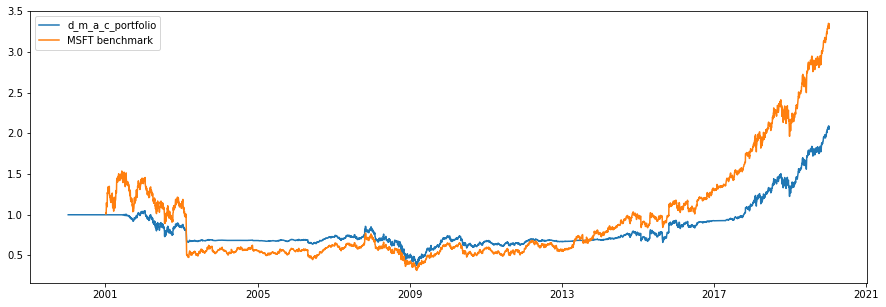

In [19]:
# Plotting AAPL benchmark and portfolio cumulative daily returns to understand d_m_a_c_trade strategy long term performance
plt.clf()
plt.figure(figsize=(15,5))
d_m_a_c_portfolio_daily_ret=d_m_a_c_perf.portfolio_value.pct_change()
MSFT_daily_ret=d_m_a_c_perf.MSFT.pct_change()

#plt.plot((1+b_t_s_portfolio_daily_ret).cumprod())
#plt.plot((1+aroon_portfolio_daily_ret).cumprod())
plt.plot((1+d_m_a_c_portfolio_daily_ret).cumprod())
plt.plot((1+MSFT_daily_ret).cumprod())

plt.legend(('d_m_a_c_portfolio','MSFT benchmark'), loc=0)

plt.show()

# Summary on d_m_a_c_strategy (buy and hold stock):

-Strategy has performed average with returns being only slightly above MSFT benchmark returns throughout the years, returns are practically a little above benchmark returns during economy crisis(2008-2009)

-The strategy then performed poorly lately by rising slower than MSFT benchmark returns

-In short, this strategy would not be suitable for this stock as a long term strategy.